# Trailer Speech Analysis – Genre-Based

This notebook analyzes speech in movie trailers, focusing on **dialogue** vs **narration** across different genres.  
Each trailer may belong to multiple genres and will be used in all relevant genre analyses.

We will analyze each genre **twice**:
1. For dialogue
2. For narration

### Data Used:
- `mtgc.csv`: Metadata with trailer ID and genre(s)
- `data/audio/`: Folder containing `.wav` files of extracted trailer audio

We will perform:
- Word count analysis
- Word cloud generation
- Sentiment analysis
- Most common word frequency analysis


## Import Libraries



## Step 1: Load Metadata

We load the trailer metadata from `Trailer_Metadata_with_Audio_Paths.csv`, which contains the YouTube ID (`mid`) and genre tags.


In [1]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from tqdm import tqdm

# Paths
audio_dir = Path("data/audio")
summary_path = Path("data/Trailer_Metadata_with_Audio_Paths.csv")

# Load metadata
summary_df = pd.read_csv(summary_path)

# Add list of genres and wav path
summary_df["genres"] = summary_df["genre_string"].apply(lambda s: [g.strip() for g in s.split(",")])
summary_df["wav_path"] = summary_df["youtube_id"].apply(lambda yid: audio_dir / f"{yid}.wav")

# Filter out missing files
summary_df = summary_df[summary_df["wav_path"].apply(lambda p: p.exists())]

# Explode genres so each row = one (trailer, genre)
exploded_df = summary_df.explode("genres").rename(columns={"genres": "genre"})
exploded_df.reset_index(drop=True, inplace=True)

exploded_df.head()


movie_title   youtube_id    imdb_id     genre_string  \
0              Now You See Me  p-pVxwaFuBs  tt1670345  crime, thriller   
1              Now You See Me  p-pVxwaFuBs  tt1670345  crime, thriller   
2  Far from the Madding Crowd  5-_9AFwMDmQ  tt2935476   drama, romance   
3  Far from the Madding Crowd  5-_9AFwMDmQ  tt2935476   drama, romance   
4       40 Days and 40 Nights  oMDXmDOyWE8  tt0243736  comedy, romance   

      genre                    wav_path  
0     crime  data/audio/p-pVxwaFuBs.wav  
1  thriller  data/audio/p-pVxwaFuBs.wav  
2     drama  data/audio/5-_9AFwMDmQ.wav  
3   romance  data/audio/5-_9AFwMDmQ.wav  
4    comedy  data/audio/oMDXmDOyWE8.wav

## Step 2: Transcribe Dialogue & Narration from Audio Files

For each trailer, we extract the spoken words using an offline automatic speech recognition (ASR) tool.  
We use `Vosk` to transcribe the `.wav` files into text. This is done for all trailers with available audio.  
Later, we will separately analyze these transcriptions by genre and by narration/dialogue.


In [2]:
import os
from pathlib import Path
from tqdm import tqdm

audio_dir = Path("data/audio")
fixed_dir = Path("data/audio_fixed")
fixed_dir.mkdir(exist_ok=True)

for wav_file in tqdm(audio_dir.glob("*.wav")):
    output_path = fixed_dir / wav_file.name
    os.system(f"ffmpeg -y -i '{wav_file}' -ac 1 -ar 16000 -sample_fmt s16 '{output_path}'")

0it [00:00, ?it/s]

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex -

In [7]:
from vosk import Model, KaldiRecognizer
import wave
import json
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# Load model
model_path = "data/vosk_model"
vosk_model = Model(model_path)


# Store transcripts
transcripts = []

print(f"Loaded {len(summary_df)} trailers.")

# Loop with tqdm progress bar
for idx, row in tqdm(summary_df.iterrows(), total=len(summary_df)):
    youtube_id = row['youtube_id']
    wav_path = Path(f"data/audio_fixed/{youtube_id}.wav")

    if not wav_path.exists():
        print(f" Missing file: {wav_path.name}")
        continue

    try:
        wf = wave.open(str(wav_path), "rb")
        if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getframerate() not in [16000, 8000]:
            print(f" Unsupported format: {wav_path.name}")
            continue

        rec = KaldiRecognizer(vosk_model, wf.getframerate())
        rec.SetWords(True)

        result_text = ""
        while True:
            data = wf.readframes(4000)
            if len(data) == 0:
                break
            if rec.AcceptWaveform(data):
                result = json.loads(rec.Result())
                result_text += result.get("text", "") + " "

        final_result = json.loads(rec.FinalResult())
        result_text += final_result.get("text", "")

        transcripts.append({
            "youtube_id": youtube_id,
            "transcript": result_text.strip()
        })

    except Exception as e:
        print(f" Error with {youtube_id}: {e}")
        continue

# Save to CSV
transcript_df = pd.DataFrame(transcripts)
transcript_df.to_csv("data/transcripts.csv", index=False)
print(" Transcriptions saved to data/transcripts.csv")


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:11:12:13:14:15
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from data/vosk_model/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:279) Loading HCLG from data/vosk_model/graph/HCLG.fst
LOG (VoskAPI:ReadDataFiles():model.cc:294) Loading words from data/vosk_model/graph/words.txt
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo data/vosk_model/graph/phones/word_boundary.int
LOG (VoskAPI:ReadDataFiles():model.cc:310) Loading subtract G.fst model from data/vo

Loaded 24 trailers.


100%|██████████| 24/24 [40:40<00:00, 101.70s/it]


 Transcriptions saved to data/transcripts.csv


## Step 3: Merge Transcripts with Genre Metadata

In this step, we will:

Load the transcript file (data/transcripts.csv)

Load the trailer genre metadata (data/downloaded_trailers_summary.csv)

Explode the genre column so that each trailer–genre combination gets its own row

Merge the transcript with genre metadata

Prepare a clean dataset for genre-level speech analysis

In [9]:
# Load transcripts
transcript_df = pd.read_csv("data/transcripts.csv")

# Split genre string into list
summary_df['genre_list'] = summary_df['genre_string'].str.split(', ')

# Explode genres into separate rows
exploded_df = summary_df.explode('genre_list').rename(columns={'genre_list': 'genre'})

# Merge transcripts with metadata
merged_df = pd.merge(transcript_df, exploded_df, on="youtube_id", how="inner")

# Filter out empty transcripts
merged_df = merged_df[merged_df['transcript'].str.strip().astype(bool)]

# Preview the merged dataset
merged_df[['youtube_id', 'genre', 'transcript']].head()

youtube_id     genre                                         transcript
0  p-pVxwaFuBs     crime  the come in close because the more you think y...
1  p-pVxwaFuBs  thriller  the come in close because the more you think y...
2  5-_9AFwMDmQ     drama  the two everything from now on you have mistre...
3  5-_9AFwMDmQ   romance  the two everything from now on you have mistre...
4  oMDXmDOyWE8    comedy  matt sullivan is a young normal healthy americ...

## Step 4:  Prepare Speech Analysis Per Genre

Now we will analyze each transcript grouped by genre. We will perform the following for each (genre, speech type) combination:

Word count

Sentiment analysis

Word frequency and top words

Word cloud

This step focuses only on dialogue (narration can be added as a second pass if separated).



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/seifelhadidi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/seifelhadidi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


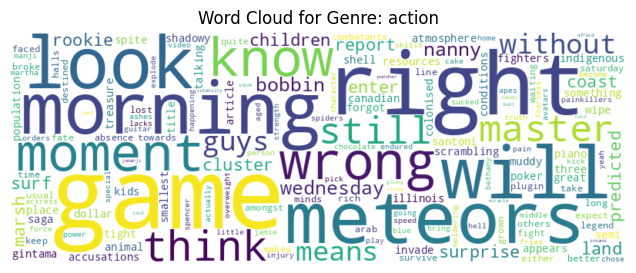

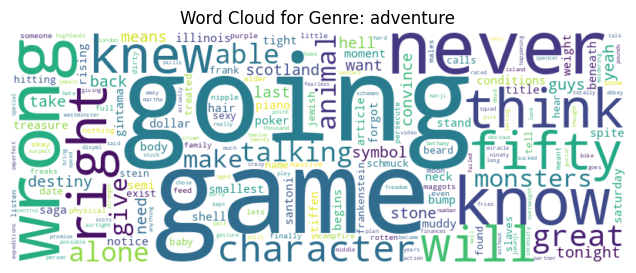

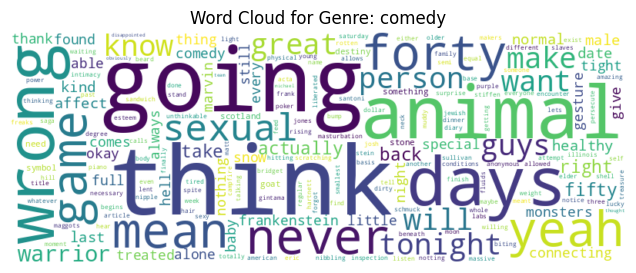

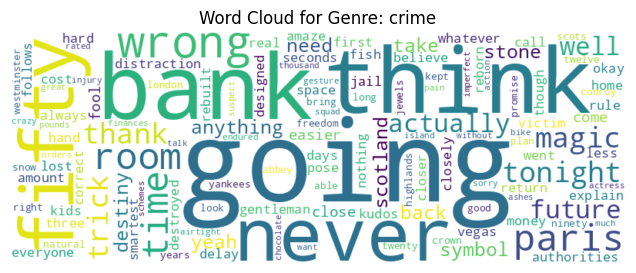

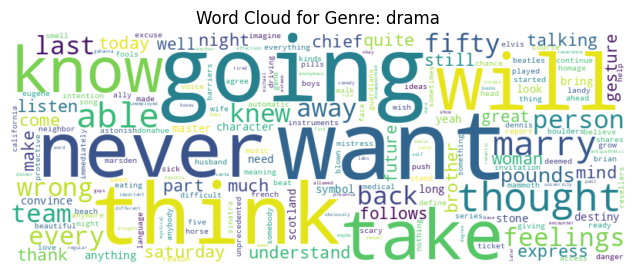

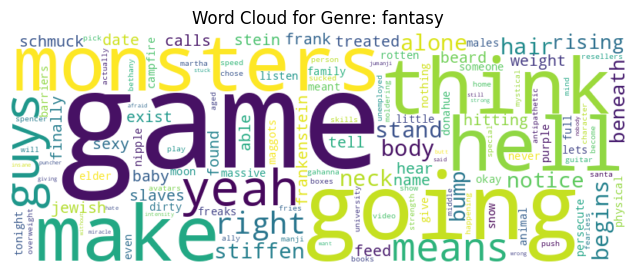

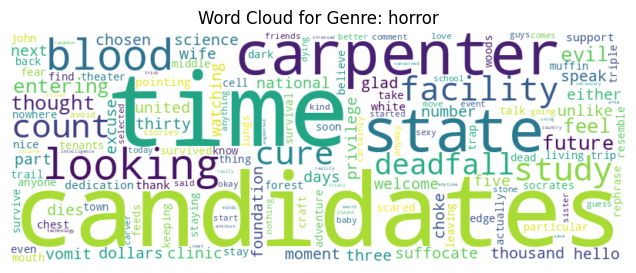

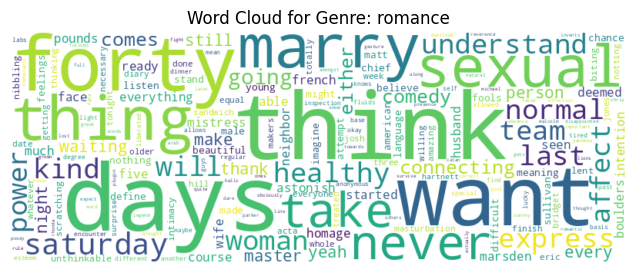

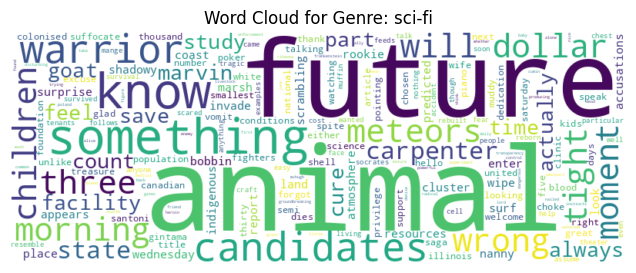

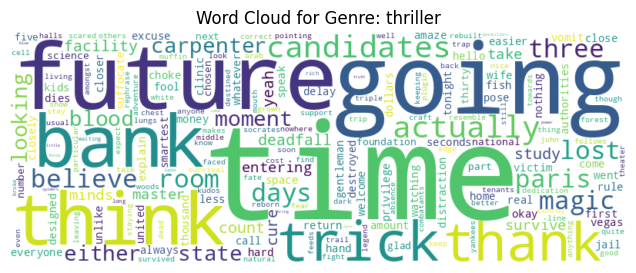

genre  word_count  sentiment  \
0     action         522     0.2817   
1  adventure         854    -0.8956   
2     comedy        1271     0.9924   
3      crime         446     0.8520   
4      drama        1287     0.9967   
5    fantasy         438    -0.9618   
6     horror         466     0.9355   
7    romance         717     0.9963   
8     sci-fi         661     0.0932   
9   thriller         755     0.7135   

                                           top_words  
0  [(that, 9), (this, 9), (game, 4), (there, 3), ...  
1  [(that, 12), (this, 10), (what, 9), (your, 5),...  
2  [(that, 20), (what, 11), (this, 10), (have, 8)...  
3  [(going, 5), (what, 5), (that, 4), (think, 3),...  
4  [(that, 13), (have, 10), (your, 9), (this, 9),...  
5  [(that, 7), (your, 4), (they, 4), (like, 4), (...  
6  [(this, 8), (that, 5), (candidates, 3), (have,...  
7  [(have, 9), (that, 8), (this, 6), (think, 5), ...  
8  [(that, 10), (this, 8), (animal, 5), (when, 4)...  
9  [(this, 12), (that, 7), (your, 6), (going, 4),...

In [15]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Make sure required NLTK resources are downloaded
nltk.download('vader_lexicon')
nltk.download('punkt')

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Store results
genre_analysis = []

# Group transcripts by genre
grouped = merged_df.groupby("genre")

for genre, group in grouped:
    all_text = " ".join(group['transcript'].values).lower()
    
    # Word count
    words = nltk.word_tokenize(all_text)
    word_count = len(words)
    
    # Sentiment score
    sentiment = sia.polarity_scores(all_text)['compound']
    
    # Top 10 most common words (excluding very short ones)
    filtered_words = [w for w in words if w.isalpha() and len(w) > 3]
    top_words = Counter(filtered_words).most_common(10)
    
    # Generate and show word cloud
    wc = WordCloud(width=800, height=300, background_color="white").generate(" ".join(filtered_words))
    plt.figure(figsize=(10, 3))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Genre: {genre}")
    plt.show()
    
    genre_analysis.append({
        "genre": genre,
        "word_count": word_count,
        "sentiment": sentiment,
        "top_words": top_words
    })

# Convert to DataFrame
genre_analysis_df = pd.DataFrame(genre_analysis)

# Display results
genre_analysis_df


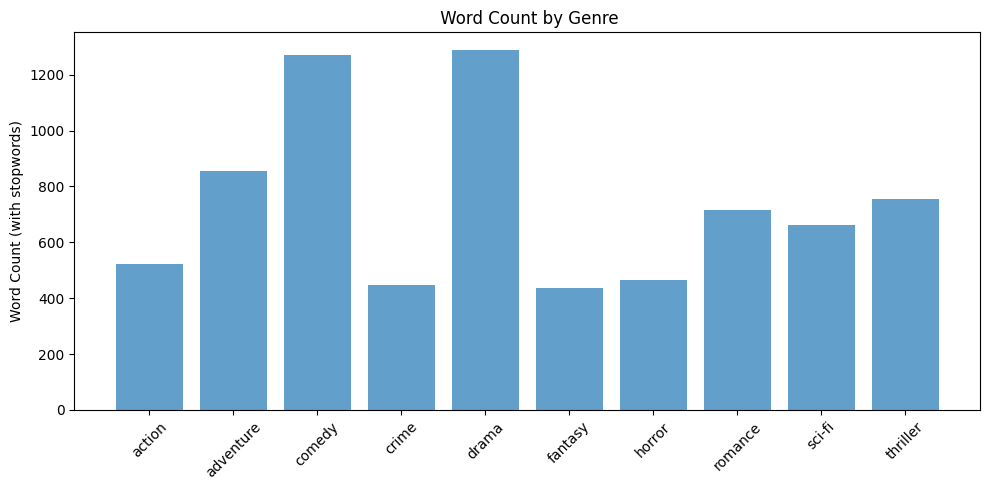

In [16]:
# Plot Word Count per Genre
plt.figure(figsize=(10, 5))
plt.bar(genre_analysis_df['genre'], genre_analysis_df['word_count'], alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel("Word Count (with stopwords)")
plt.title(" Word Count by Genre")
plt.tight_layout()
plt.show()



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/seifelhadidi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/seifelhadidi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/seifelhadidi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


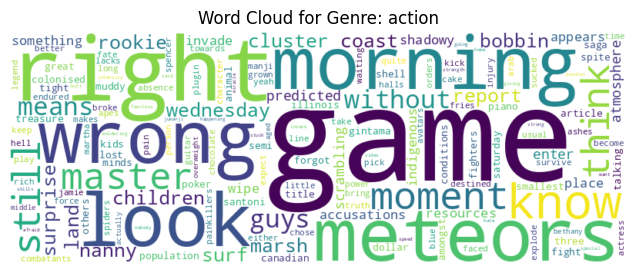

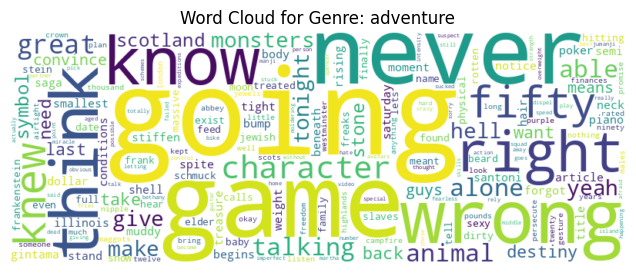

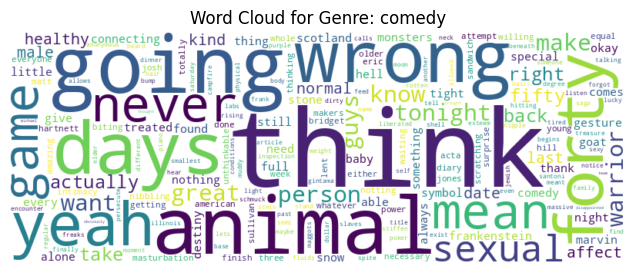

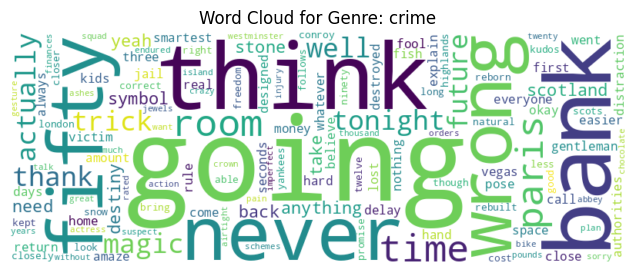

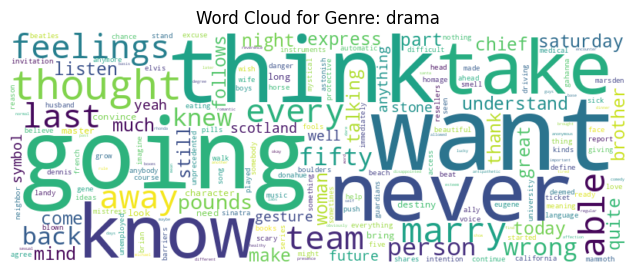

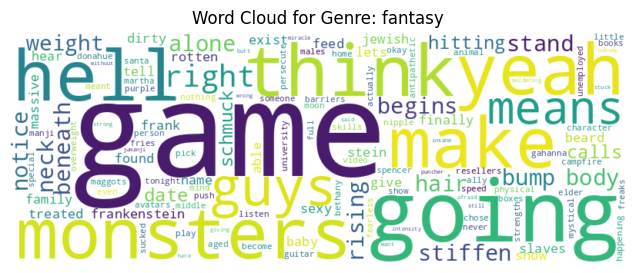

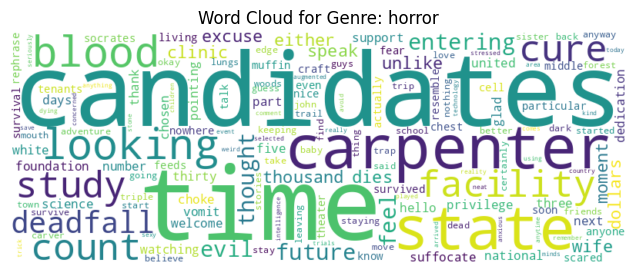

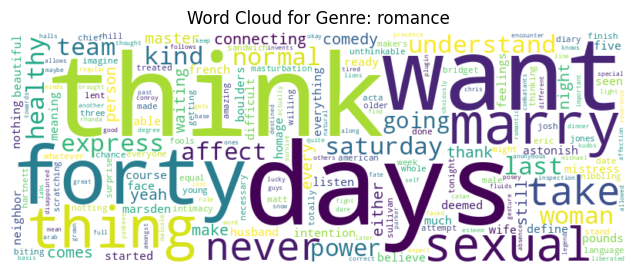

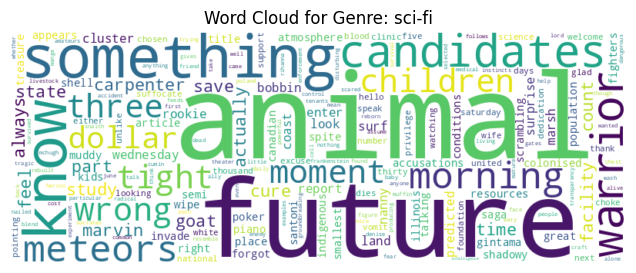

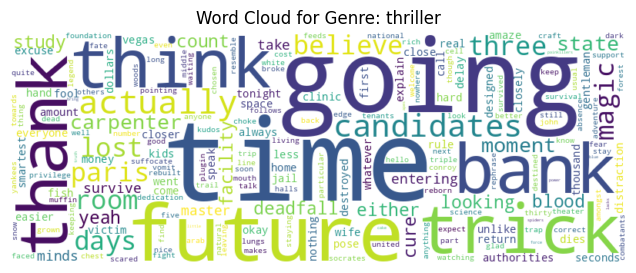

genre  word_count  sentiment  \
0     action         182     0.2817   
1  adventure         303    -0.8956   
2     comedy         471     0.9924   
3      crime         162     0.8520   
4      drama         471     0.9967   
5    fantasy         148    -0.9618   
6     horror         175     0.9355   
7    romance         275     0.9963   
8     sci-fi         260     0.0932   
9   thriller         275     0.7135   

                                           top_words  
0  [(game, 4), (right, 3), (morning, 2), (meteors...  
1  [(going, 5), (game, 5), (like, 4), (never, 4),...  
2  [(think, 7), (like, 7), (going, 6), (animal, 6...  
3  [(going, 5), (think, 3), (bank, 3), (never, 3)...  
4  [(want, 7), (going, 7), (think, 6), (never, 5)...  
5  [(like, 4), (game, 4), (going, 3), (think, 2),...  
6  [(candidates, 3), (carpenter, 2), (looking, 2)...  
7  [(think, 5), (days, 5), (like, 4), (want, 4), ...  
8  [(animal, 5), (future, 4), (something, 3), (kn...  
9  [(going, 4), (future, 4), (think, 3), (bank, 3...

In [17]:
###  Genre-Level Speech Analysis without stopwords (Word Count, Sentiment, Top Words, Word Cloud)

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

# Initialize tools
sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))

# Store analysis results
genre_analysis = []

# Group by genre
grouped = merged_df.groupby("genre")

for genre, group in grouped:
    all_text = " ".join(group['transcript'].values).lower()
    
    # Tokenize and clean words
    words = nltk.word_tokenize(all_text)
    filtered_words = [w for w in words if w.isalpha() and len(w) > 3 and w not in stop_words]
    
    # Word count (after removing stopwords)
    word_count = len(filtered_words)
    
    # Sentiment analysis (on full raw text)
    sentiment = sia.polarity_scores(all_text)['compound']
    
    # Top 10 words
    top_words = Counter(filtered_words).most_common(10)
    
    # Word cloud
    wc = WordCloud(width=800, height=300, background_color="white").generate(" ".join(filtered_words))
    plt.figure(figsize=(10, 3))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Genre: {genre}")
    plt.show()
    
    # Append results
    genre_analysis.append({
        "genre": genre,
        "word_count": word_count,
        "sentiment": sentiment,
        "top_words": top_words
    })

# Create DataFrame
genre_analysis_df = pd.DataFrame(genre_analysis)

# Display summary
display(genre_analysis_df)


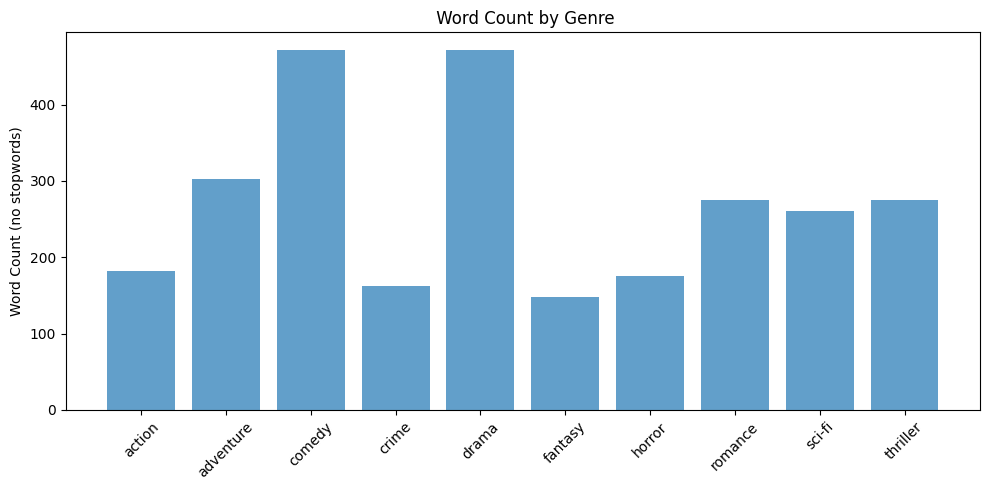

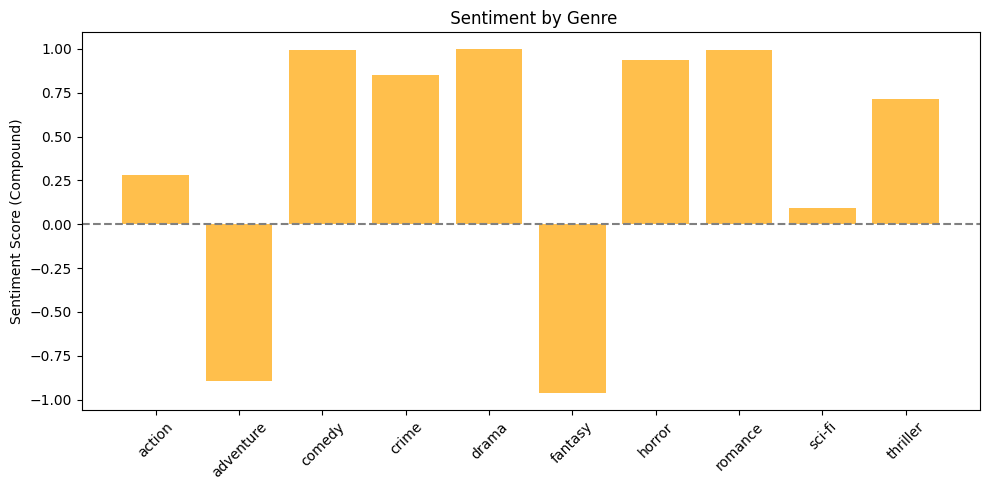

In [18]:
# Plot Word Count per Genre
plt.figure(figsize=(10, 5))
plt.bar(genre_analysis_df['genre'], genre_analysis_df['word_count'], alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel("Word Count (no stopwords)")
plt.title(" Word Count by Genre")
plt.tight_layout()
plt.show()

# Plot Sentiment Score per Genre
plt.figure(figsize=(10, 5))
plt.bar(genre_analysis_df['genre'], genre_analysis_df['sentiment'], color='orange', alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel("Sentiment Score (Compound)")
plt.title(" Sentiment by Genre")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()